<a href="https://colab.research.google.com/github/mobarakol/Applied_Deep_Learning/blob/main/LeNet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os                                                    # Import os for file path handling
import gzip                                                  # Import gzip to read compressed files
import numpy as np                                           # Import numpy for numerical operations
import torch                                                 # Import PyTorch
from torch.utils.data import Dataset, DataLoader             # Import PyTorch Dataset and DataLoader
from torchvision import datasets                             # Import torchvision for loading datasets
import torch.nn as nn                                        # Import nn for building neural networks
import torch.optim as optim                                  # Import optim for optimization algorithms
import matplotlib.pyplot as plt                              # Import matplotlib for plotting

# Directory to store MNIST data
DATA_DIR = './data/mnist'                                    # Path to store the MNIST dataset

# Download MNIST using torchvision
datasets.MNIST(root=DATA_DIR, train=True, download=True)     # Download training data
datasets.MNIST(root=DATA_DIR, train=False, download=True)    # Download test data

# File paths for extracted data
train_image_file = os.path.join(DATA_DIR, 'MNIST/raw/train-images-idx3-ubyte.gz')  # Path to training images
train_label_file = os.path.join(DATA_DIR, 'MNIST/raw/train-labels-idx1-ubyte.gz')  # Path to training labels
test_image_file = os.path.join(DATA_DIR, 'MNIST/raw/t10k-images-idx3-ubyte.gz')    # Path to test images
test_label_file = os.path.join(DATA_DIR, 'MNIST/raw/t10k-labels-idx1-ubyte.gz')    # Path to test labels

# Custom Dataset class for MNIST
class MNISTDataset(Dataset):
    def __init__(self, image_file, label_file):
        self.image_file = image_file                            # Store the file path for images
        self.label_file = label_file                            # Store the file path for labels

        # Load the images and labels into memory
        with gzip.open(self.image_file, 'rb') as f:
            self.images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
            # Read and reshape images to (N, 1, 28, 28) and normalize to [0, 1]

        with gzip.open(self.label_file, 'rb') as f:
            self.labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Read labels

    def __len__(self):
        return len(self.images)                              # Return the total number of samples

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx])               # Convert image to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert label to tensor
        return image, label

# Create Dataset instances for training and testing
train_dataset = MNISTDataset(train_image_file, train_label_file)   # Create training dataset
test_dataset = MNISTDataset(test_image_file, test_label_file)      # Create test dataset

# Split training into train/validation sets
train_size = int(0.8 * len(train_dataset))                       # 80% for training
val_size = len(train_dataset) - train_size                       # 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # DataLoader for training
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)     # DataLoader for validation
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)   # DataLoader for testing

# Define LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # Conv layer 1 (input: 1 channel, output: 6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # Conv layer 2 (input: 6 channels, output: 16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                            # Fully connected layer 1
        self.fc2 = nn.Linear(120, 84)                                     # Fully connected layer 2
        self.fc3 = nn.Linear(84, 10)                                      # Fully connected layer 3 (output: 10 classes)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)                 # Average pooling layer
        self.relu = nn.ReLU()                                              # ReLU activation

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 16 * 5 * 5)              # Flatten tensor
        x = self.relu(self.fc1(x))              # FC1 -> ReLU
        x = self.relu(self.fc2(x))              # FC2 -> ReLU
        x = self.fc3(x)                         # FC3
        return x

# Instantiate model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model = LeNet().to(device)                                             # Move model to device
criterion = nn.CrossEntropyLoss()                                      # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)      # SGD optimizer

# Function to train one epoch
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()                                                      # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()                                           # Reset gradients
        outputs = model(images)                                         # Forward pass
        loss = criterion(outputs, labels)                               # Compute loss
        loss.backward()                                                 # Backpropagation
        optimizer.step()                                                # Update weights

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)                            # Get predicted labels
        correct += (predicted == labels).sum().item()                   # Count correct predictions
        total += labels.size(0)

    accuracy = 100 * correct / total                                     # Compute accuracy
    return running_loss / len(train_loader), accuracy

# Function to validate model
def validate(model, val_loader, criterion):
    model.eval()                                                         # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(val_loader), accuracy

# Training loop
num_epochs = 10
best_val_accuracy = 0.0
best_model_path = './best_lenet_model.pth'

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validate(model, val_loader, criterion)

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with accuracy: {best_val_accuracy:.2f}%\n")

# Load best model
model.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_val_accuracy:.2f}%")

# Evaluate on test set
test_loss, test_accuracy = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/10]
Train Loss: 0.7349, Train Accuracy: 75.05%
Validation Loss: 0.1852, Validation Accuracy: 94.06%
Best model saved with accuracy: 94.06%

Epoch [2/10]
Train Loss: 0.1321, Train Accuracy: 95.88%
Validation Loss: 0.1105, Validation Accuracy: 96.54%
Best model saved with accuracy: 96.54%

Epoch [3/10]
Train Loss: 0.0875, Train Accuracy: 97.31%
Validation Loss: 0.0857, Validation Accuracy: 97.20%
Best model saved with accuracy: 97.20%

Epoch [4/10]
Train Loss: 0.0674, Train Accuracy: 97.86%
Validation Loss: 0.0659, Validation Accuracy: 97.89%
Best model saved with accuracy: 97.89%

Epoch [5/10]
Train Loss: 0.0545, Train Accuracy: 98.24%
Validation Loss: 0.0695, Validation Accuracy: 97.77%
Epoch [6/10]
Train Loss: 0.0455, Train Accuracy: 98.59%
Validation Loss: 0.0505, Validation Accuracy: 98.33%
Best model saved with accuracy: 98.33%

Epoch [7/10]
Train Loss: 0.0387, Train Accuracy: 98.76%
Validation Loss: 0.0550, Validation Accuracy: 98.17%
Epoch [8/10]
Train Loss: 0.0352, Trai

Best model loaded with accuracy: 98.56%


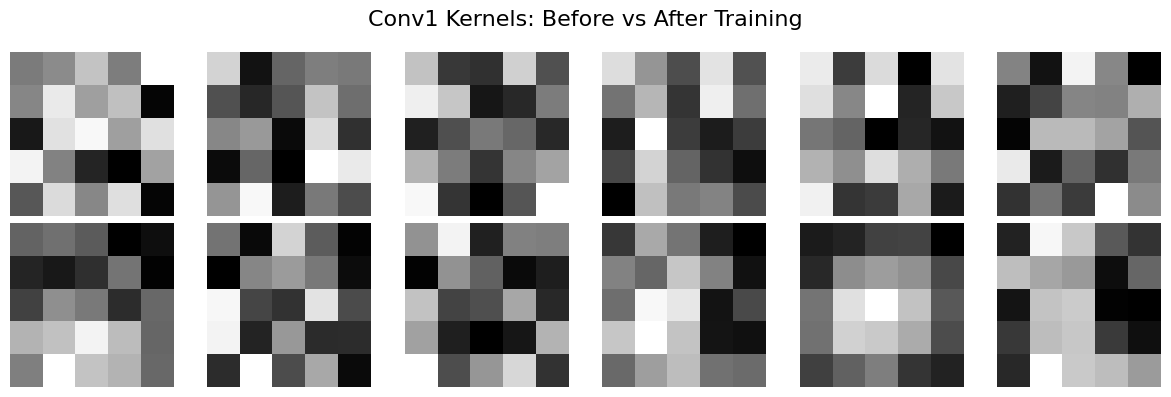

In [11]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import gzip
import torch.nn as nn
import torch.optim as optim

# Function to plot all filters in two rows: before → top, after → bottom
def plot_kernels_before_after(model_before, model_after, layer_name, title):
    layer_before = dict(model_before.named_modules())[layer_name].weight.data.cpu().numpy()
    layer_after = dict(model_after.named_modules())[layer_name].weight.data.cpu().numpy()
    num_kernels = layer_before.shape[0]

    fig, axs = plt.subplots(2, num_kernels, figsize=(num_kernels * 2, 4)) # 2 rows, num_kernels columns

    fig.suptitle(title, fontsize=16)

    for i in range(num_kernels):
        # Plot BEFORE training
        axs[0, i].imshow(layer_before[i, 0], cmap='gray')
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel("Before", fontsize=12)

        # Plot AFTER training
        axs[1, i].imshow(layer_after[i, 0], cmap='gray')
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel("After", fontsize=12)

    plt.tight_layout()
    plt.show()

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create two models:
# 1. model_before - for showing initial random weights
# 2. model_after - for showing learned weights after training
model_before = LeNet().to(device)
model_after = LeNet().to(device)

# Load trained model weights into model_after
best_model_path = './best_lenet_model.pth'
model_after.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_val_accuracy:.2f}%")

# Plot all filters in two rows (before and after training)
plot_kernels_before_after(model_before, model_after, 'conv1', 'Conv1 Kernels: Before vs After Training')


Best model loaded with accuracy: 98.56%


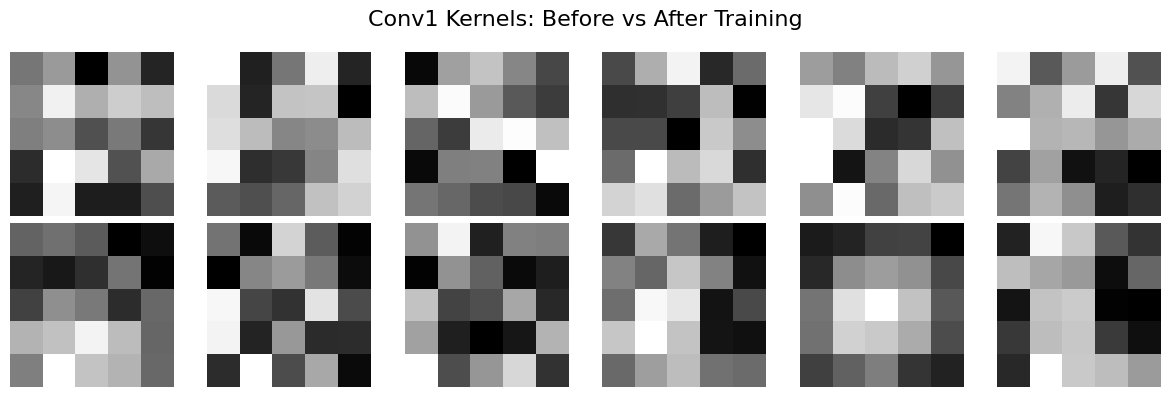

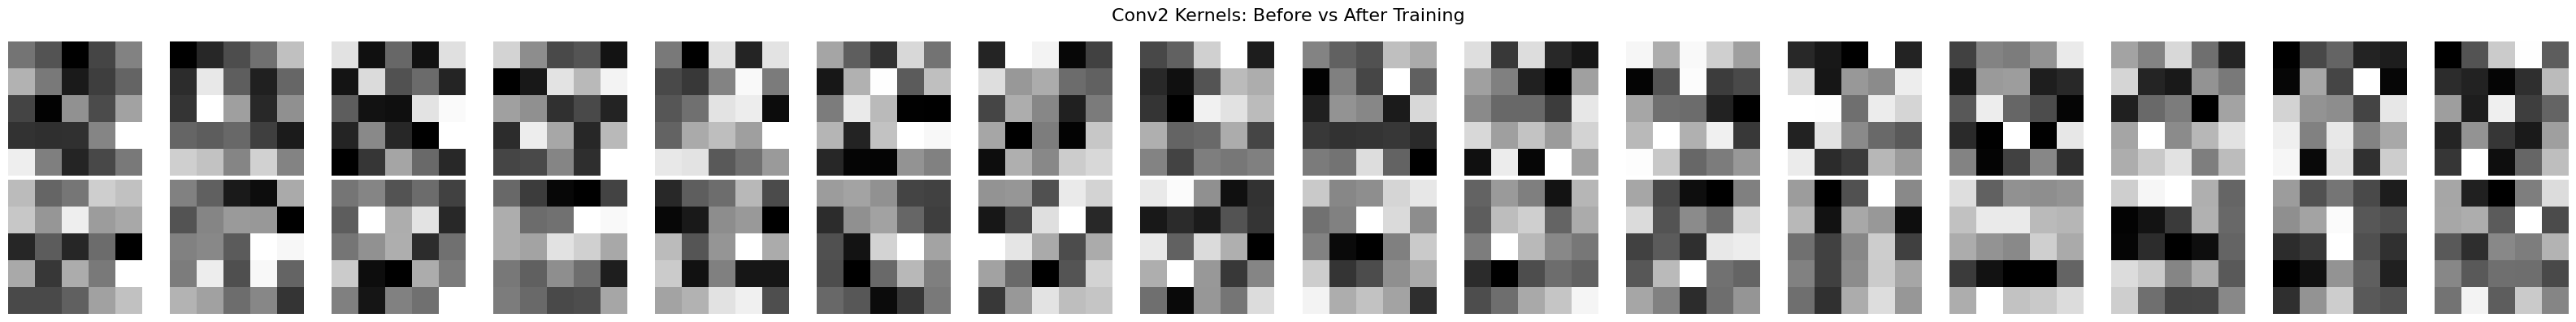

In [12]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import gzip
import torch.nn as nn
import torch.optim as optim

# Function to plot all filters in two rows: before → top, after → bottom
def plot_kernels_before_after(model_before, model_after, layer_name, title):
    layer_before = dict(model_before.named_modules())[layer_name].weight.data.cpu().numpy()
    layer_after = dict(model_after.named_modules())[layer_name].weight.data.cpu().numpy()
    num_kernels = layer_before.shape[0]

    fig, axs = plt.subplots(2, num_kernels, figsize=(num_kernels * 2, 4))  # 2 rows, num_kernels columns

    fig.suptitle(title, fontsize=16)

    for i in range(num_kernels):
        # Plot BEFORE training
        axs[0, i].imshow(layer_before[i, 0], cmap='gray')
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel("Before", fontsize=12)

        # Plot AFTER training
        axs[1, i].imshow(layer_after[i, 0], cmap='gray')
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel("After", fontsize=12)

    plt.tight_layout()
    plt.show()

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create two models:
# 1. model_before - for showing initial random weights
# 2. model_after - for showing learned weights after training
model_before = LeNet().to(device)
model_after = LeNet().to(device)

# Load trained model weights into model_after
best_model_path = './best_lenet_model.pth'
model_after.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_val_accuracy:.2f}%")

# ✅ Plot Conv1 filters (before and after training)
plot_kernels_before_after(model_before, model_after, 'conv1', 'Conv1 Kernels: Before vs After Training')

# ✅ Plot Conv2 filters (before and after training)
plot_kernels_before_after(model_before, model_after, 'conv2', 'Conv2 Kernels: Before vs After Training')


Best model loaded with accuracy: 98.56%


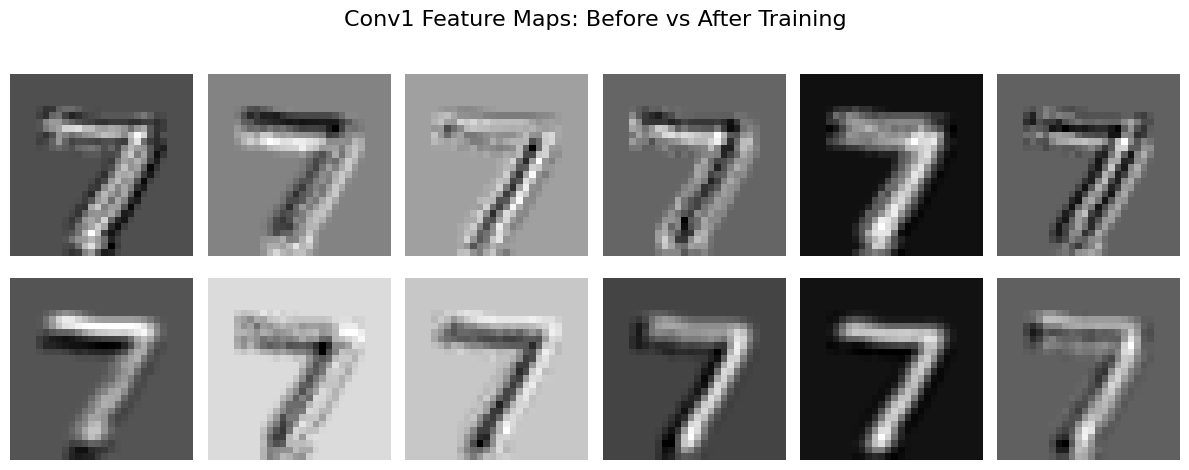

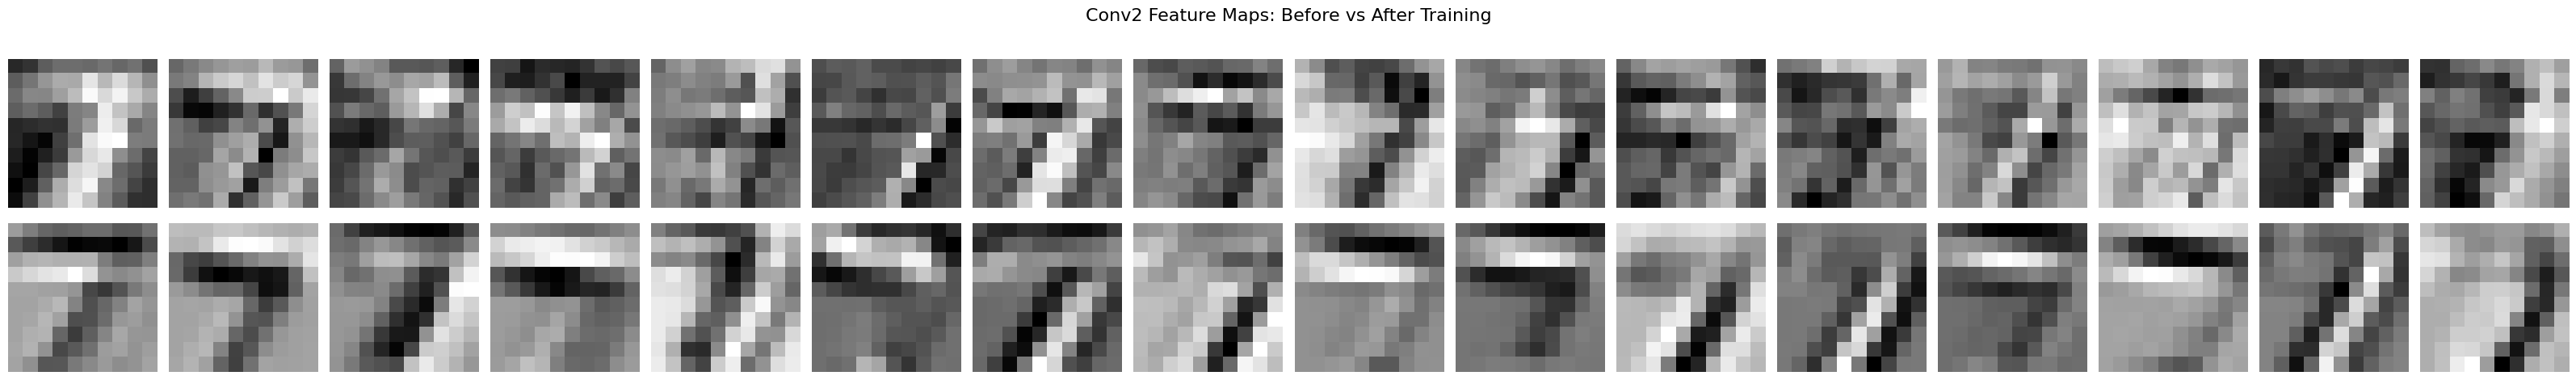

In [13]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import gzip
import torch.nn as nn
import torch.optim as optim

# Function to extract feature maps using forward hooks
def get_feature_maps(model, layer_name, input_sample):
    activation = {}

    def hook_fn(module, input, output):
        activation[layer_name] = output.detach()

    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    _ = model(input_sample)  # Forward pass through the model
    handle.remove()

    feature_maps = activation[layer_name].cpu().numpy()
    return feature_maps

# Function to plot feature maps before and after training
def plot_feature_maps(before_maps, after_maps, title):
    num_maps = before_maps.shape[1]

    fig, axs = plt.subplots(2, num_maps, figsize=(num_maps * 2, 5))

    fig.suptitle(title, fontsize=16)

    for i in range(num_maps):
        # Before training
        axs[0, i].imshow(before_maps[0, i], cmap='gray')
        axs[0, i].axis('off')
        if i == 0:
            axs[0, i].set_ylabel("Before", fontsize=12)

        # After training
        axs[1, i].imshow(after_maps[0, i], cmap='gray')
        axs[1, i].axis('off')
        if i == 0:
            axs[1, i].set_ylabel("After", fontsize=12)

    plt.tight_layout()
    plt.show()

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_before = LeNet().to(device)
model_after = LeNet().to(device)

# Load trained model weights into model_after
best_model_path = './best_lenet_model.pth'
model_after.load_state_dict(torch.load(best_model_path, weights_only=True))
print(f"Best model loaded with accuracy: {best_val_accuracy:.2f}%")

# Load a sample from test set
sample_image, _ = test_dataset[0]  # Take the first test sample
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# ✅ Extract feature maps before and after training for conv1
before_maps_conv1 = get_feature_maps(model_before, 'conv1', sample_image)
after_maps_conv1 = get_feature_maps(model_after, 'conv1', sample_image)

# ✅ Plot Conv1 feature maps (before and after training)
plot_feature_maps(before_maps_conv1, after_maps_conv1, 'Conv1 Feature Maps: Before vs After Training')

# ✅ Extract feature maps before and after training for conv2
before_maps_conv2 = get_feature_maps(model_before, 'conv2', sample_image)
after_maps_conv2 = get_feature_maps(model_after, 'conv2', sample_image)

# ✅ Plot Conv2 feature maps (before and after training)
plot_feature_maps(before_maps_conv2, after_maps_conv2, 'Conv2 Feature Maps: Before vs After Training')
